## LSTM Activation- Hand picked cases

After studying the [Effectiveness of RNNs and LSTMs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), we were eager to duplicate and enhance the results showcased in this blog. After trying character prediction using LSTM model on [Shakespeare data](http://www.gutenberg.org/ebooks/100), we wanted to visualize the activations of the LSTM cells to find some pattern in the way the cells are storing/processing information.

In [1]:
# Import stuff

import numpy as np
import six
import tensorflow as tf
import time
import os
import seaborn as sns
from matplotlib import pyplot as plt

The main purpose of this notebook is to visualize the LSTM cell activations of language model. The training part of the model and the prediction results can be found [here](https://github.com/InFoCusp/lstm_deepdive/blob/master/shakespeare_writing_style_lstm.ipynb). Here, we are directly loading the saved weights and showcasing some of the trends that we obsereved. 

In [2]:
# Function to convert text into integers (also dropping any non-ascii characters)

def transform(txt, pad_to=None):
    output = np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)
    if pad_to is not None:
        output = output[:pad_to]
        output = np.concatenate([
            np.zeros([pad_to - len(txt)], dtype=np.int32),
            output,
        ])
    return output

In [3]:
def lstm_model(seq_len=100, batch_size=None, stateful=True):
    """Language model: predict the next word given the current word."""
    source = tf.keras.Input(
      name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

    embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
    lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
    predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='softmax'))(lstm_2)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_char,lstm_1,lstm_2])
    # Here we are taking LSTM cell states of both the layers alongwith the output predicted character
    
    model.compile(
      optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
    return model

In [4]:
BATCH_SIZE = 1
PREDICT_LEN = 250
EMBEDDING_DIM = 512

In [5]:
# Defining the prediction model 

BATCH_SIZE = 1
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)

# A explained in the training notebook, Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
prediction_model.load_weights('model_weights/shakespeare_handpicked_heatmap.h5')

##### Prediction Function:

This function takes a test text sequence and the trained model as inputs. <br>
It predicts the next character for each input character from the input text sequence. Alongwith the generated output, we are also storing the LSTM cell states at each character level. The LSTM layer has 512 cells. Thus, we have [512 x len(`seed_text`)] number of states at each layer. This model has two such LSTM layers. <br>
After storing the LSTM cell values, the function plots the heatmap of the cell values of layer number given by `node_num` and plots the activations of the cells between `start_node` and `end_node` at each input step of seed text. The cell values range from -1 to 1 and the colors of the cells indicate this range. Both positive and negative extremities are considered as useful activations.

In [8]:
def predict(seed_text, prediction_model, start_node, end_node, node_num):
    seed = transform(seed_txt)
    seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)
    PREDICT_LEN = len(seed_txt)-1
    print("Length of input text: " + str(PREDICT_LEN))
    
    predicted_char_o = []
    lstm_1_o = []
    lstm_2_o = []

    # First, run the seed forward to prime the state of the model.
    prediction_model.reset_states()
    
    for i in range(len(seed_txt) - 1):
        [predicted_char_temp,lstm_1_temp,lstm_2_temp] = prediction_model.predict(seed[:, i:i + 1])
        predicted_char_o.append(predicted_char_temp[0,0,:])
        lstm_1_o.append(lstm_1_temp[0,0,:])
        lstm_2_o.append(lstm_2_temp[0,0,:])
    
    print("LSTM Layer" + str(node_num))
    plt.figure(figsize=[24,4])
    if node_num == 1:
        ax2 = sns.heatmap(np.array(lstm_1_o).T[start_node:end_node,:] ,xticklabels=list(seed_txt), )
    else:
        ax2 = sns.heatmap(np.array(lstm_2_o).T[start_node:end_node,:] ,xticklabels=list(seed_txt), )
    ax2.tick_params(labelsize=18)
    plt.show()
    
    return

##### Analysis:

Now, we analyse some special cases by providing the input text accordingly. We plot the heat-map of the cell which shows high or low activation.

#### 1. Full Stops:

Observe how the cells give negative activation (black, dark purple in heatmap) at full-stops. There is no activation at the larger space provided at the end of the input text. 

Length of input text: 99


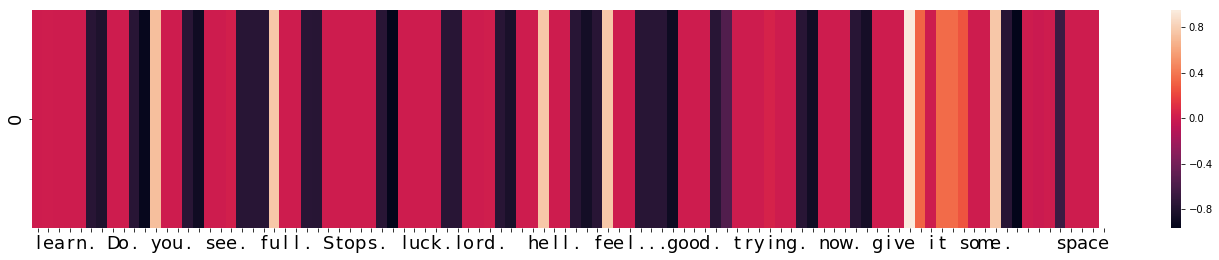

Length of input text: 99


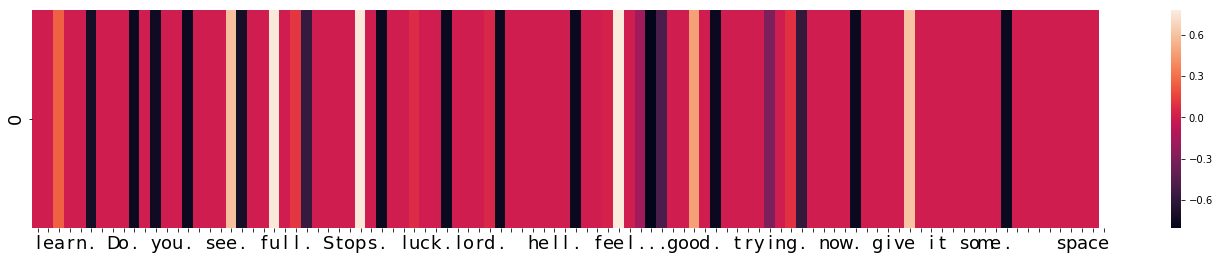

In [9]:
seed_txt = 'learn. Do. you. see. full. Stops. luck.lord.  hell. feel...good. trying. now. give it some.    space'
predict(seed_txt,prediction_model,133,134,1)
predict(seed_txt,prediction_model,131,132,2)

#### 2. 'a' 'Ar':

Here, one can observe that this particular node/cell of LSTM Layer 2 gives negative activation followed by a positive activation whenever sub-string `ar` is encountered after a space (There is no activation when `ar` is in between a word like in 'learn'). Also interestingly, there is strong negative activation when the string `an` is encountered. Capital letter makes the activations a little less. One can try for other input strings of more variety of words containing `an, a, artist... ` and soon and observe different patterns. 

Length of input text: 102


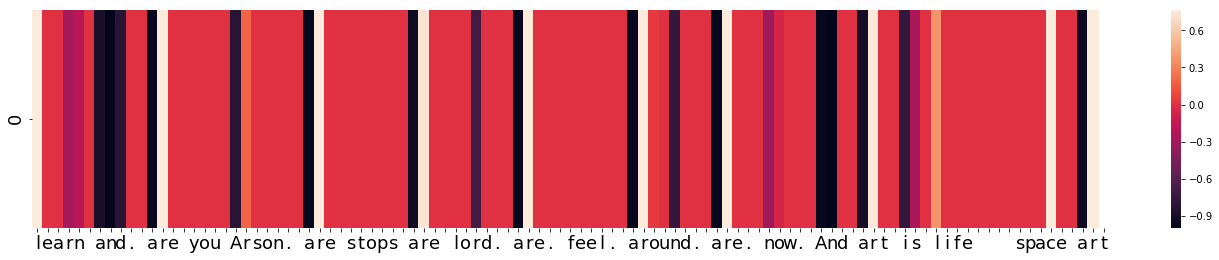

In [10]:
seed_txt = 'learn and. are you Arson. are stops are lord. are. feel. around. are. now. And art is life    space art'
predict(seed_txt,prediction_model,386,387,2)

#### 3. 'the'  and 'he':

This is yet another interesting observation where the particular node of LSTM triggers and gives a strong positive activation whenever the string `the` is encountered. We tried to observe whether the same kind of activation can be observed for strings succeeded by `he` (can be observed in words `she, shelter, check`). The node showed no such activation at such words (slight purple). However, the node showed strong activation for variety of strings having sub-string `the` (such as then, they, their, there).

Length of input text: 122


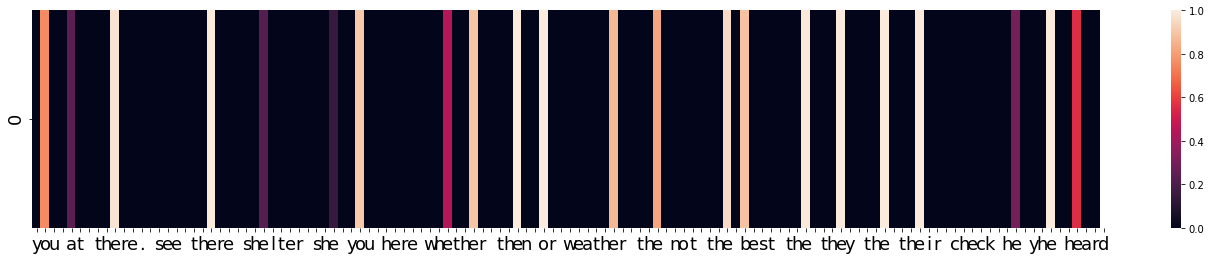

In [11]:
seed_txt = 'you at there. see there shelter she you here whether then or weather the not the best the they the their check he yhe heard'
predict(seed_txt,prediction_model,99,100,2)

#### 4. Capital Letters:

Here, we can clearly see activations at capital letters even though the activations are a bit delayed (starting from the second or third capital letter).

Length of input text: 97


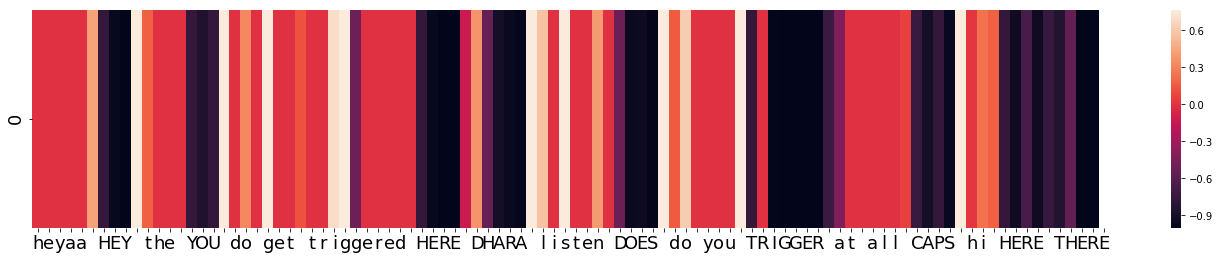

In [12]:
seed_txt = 'heyaa HEY the YOU do get triggered HERE DHARA listen DOES do you TRIGGER at all CAPS hi HERE THERE'
#predict(seed_txt,prediction_model,266,267,1) #266 267
predict(seed_txt,prediction_model,156,157,2)

#### 5. Common words starting with 'a', 'o' and 'i' 

This cell of LSTM layer 2 is an indication of the fact that LSTM nodes can store information of more than one manner. Here, the cell gives activations for words having common sub-strings such as `an, is, and, in, at, I`. This cell can be explored for more input strings and more interesting observations can be found out. 

Length of input text: 128


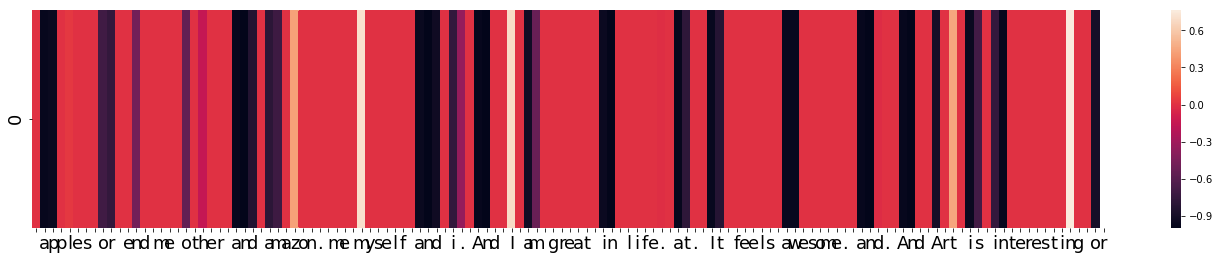

In [13]:
seed_txt = ' apples or end me other and amazon. me myself and i. And I am great in life. at. It feels awesome. and. And Art is interesting or'
predict(seed_txt,prediction_model,386,387,2)

Thus, we can observe how the LSTM is able to learn patterns. Feel free to play around and explore more! :)